In [1]:
import sys
sys.path.append("../../")

import torch
import torchvision.utils
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader
from torchvision import models
from torchsummary import summary

import numpy as np
import cv2
import pandas as pd

import src.dataPreparation.CreatePartial as create_partial
import src.neuralNetworksArch.BstCnn as bst
import src.utils.Visual as vis
import src.utils.Checkpoint as ckp
import src.utils.Metrics as metrics

from src.config.Param import *

In [2]:
MODEL_PATH = [
    '../../models/PARTIAL_1 #1 - CUHK03.pth',
    '../../models/PARTIAL_1 #2 - CUHK03.pth',
    '../../models/PARTIAL_1 #3 - CUHK03.pth'
]
DATATEST_PATH = '../../dataset/testing/testing.csv'
IMAGES_PATH = '../../dataset/testing/images/full/'
IMAGES_OCCL_PATH = '../../dataset/testing/images/occl_20/'

In [3]:
def cv_image2tensor(img, convert=True):
    if convert:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[:, :, ::-1].transpose((2, 0, 1)).copy()
    img = torch.from_numpy(img).float() / 255.0
    img = [img]
    img_tensors = torch.stack(img)

    return img_tensors

In [13]:
import torch.nn as nn

class BstCnn2(nn.Module):
    def __init__(self):
        super(BstCnn2, self).__init__()

        self.conv5x5_1 = nn.Sequential(
            nn.ReflectionPad2d(2),
            nn.Conv2d(3, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16)
        )

        self.conv3x3_1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16)
        )

        self.conv3x3_2 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(35, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16)
        )

        self.conv1x1_2 = nn.Sequential(
            nn.Conv2d(35, 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16)
        )

        self.conv1x1_3 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16)
        )

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.avgpool = nn.AdaptiveAvgPool2d((8, 8)) # partial images

        self.fc = nn.Sequential(
            nn.Linear(16*8*8, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            
            nn.Linear(1024, 512),
        )

        self._initialize_weights()

    def forward_once(self, x):
        out_5x5 = self.conv5x5_1(x)
        out_3x3 = self.conv3x3_1(x)
        output = torch.cat([out_5x5, out_3x3, x], 1)
        output = self.maxpool(output)
        
        out_3x3 = self.conv3x3_2(output)
        out_1x1 = self.conv1x1_2(output)
        output = torch.cat([out_3x3, out_1x1], 1)
        output = self.maxpool(output)

        out_1x1 = self.conv1x1_3(output)
        output = self.avgpool(out_1x1)

        output = output.reshape(output.size(0), -1)
        output = self.fc(output)

        return output

    def forward(self, input1, input2, input3=None):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        if input3 == None:
            return output1, output2
        else:
            output3 = self.forward_once(input3)
            return output1, output2, output3

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [14]:
models = []
for index, path in enumerate(MODEL_PATH):
    data = {}
    if index == 0:
        model  = bst.BstCnn()
    else:
        model = BstCnn2()
    checkpoint = ckp.load_checkpoint(load_dir=path)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    
    data['id'] = 'PART-' + str(index+1)
    data['model'] = model
    data['min_dist'] = checkpoint['dist'][0]
    data['max_dist'] = checkpoint['dist'][1]
    data['threshold'] = checkpoint['threshold']
    models.append(data)

PART-1 DISTANCE => 0.24835978380301493
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.06217564811582806
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.2251099805734065
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.09469395287528429
actual thresh => 0.19000000000000003
actual label => 0


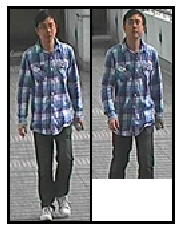


PART-1 DISTANCE => 0.35634796752581427
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 5.497464184747773e-06
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.38860355075311037
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.14899030365578494
actual thresh => 0.19000000000000003
actual label => 0


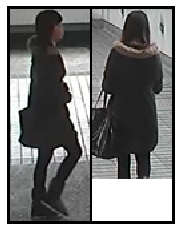


PART-1 DISTANCE => 0.41091706328473687
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.40161450719192887
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5341689309208408
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4299859031562729
actual thresh => 0.19000000000000003
actual label => 0


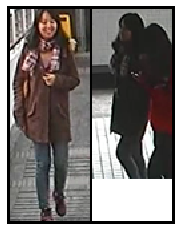


PART-1 DISTANCE => 0.22173578204803027
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.24882901410581698
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.17110443066103836
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.2278654510053039
actual thresh => 0.19000000000000003
actual label => 0


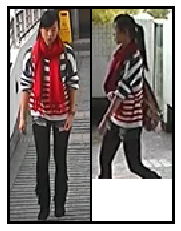


PART-1 DISTANCE => 0.268747334065296
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 5.497464184747773e-06
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.224204498836748
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.0985903665804088
actual thresh => 0.19000000000000003
actual label => 0


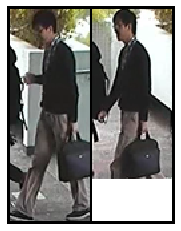


PART-1 DISTANCE => 0.4349723091265425
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.14338421208297802
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.39451645813147884
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.1658977534516043
actual thresh => 0.19000000000000003
actual label => 0


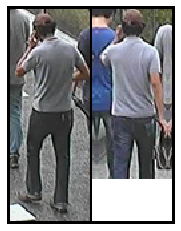


PART-1 DISTANCE => 0.2307904807016819
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.484574619121857
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.2511686887482209
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.38713660536309474
actual thresh => 0.19000000000000003
actual label => 0



PART-1 DISTANCE => 0.39052972044783635
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 5.497464184747773e-06
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.31481055006966424
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.14106805410350015
actual thresh => 0.19000000000000003
actual label => 0


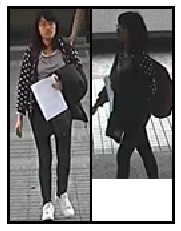


PART-1 DISTANCE => 0.2854542039192279
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.47594437980641185
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5229075346088321
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.44723897558945913
actual thresh => 0.19000000000000003
actual label => 0


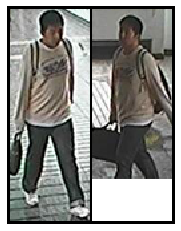


PART-1 DISTANCE => 0.5383337867652153
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.018135977467811284
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.32971356173005417
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.1736094696990539
actual thresh => 0.19000000000000003
actual label => 0


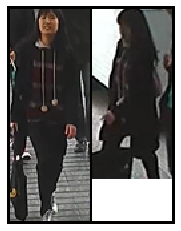


PART-1 DISTANCE => 0.368794527487887
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.1501250488164212
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.1656281914476961
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.19695957307696932
actual thresh => 0.19000000000000003
actual label => 0


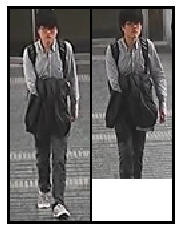


PART-1 DISTANCE => 0.41800984971865235
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.3644739428920568
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.7077380274987327
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4438339411787111
actual thresh => 0.19000000000000003
actual label => 0


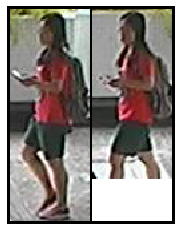


PART-1 DISTANCE => 0.3954615907518813
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.4448724598228255
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.4256514749621592
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.43114608903650337
actual thresh => 0.19000000000000003
actual label => 0


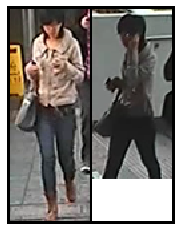


PART-1 DISTANCE => 0.2694713108711559
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.2650734276594219
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.42643539533360597
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.2982253978366055
actual thresh => 0.19000000000000003
actual label => 0


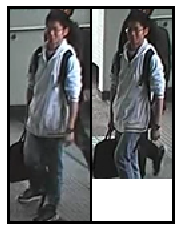


PART-1 DISTANCE => 0.28432141243077075
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.05310445358683542
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.3591933012561939
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.12870294273739294
actual thresh => 0.19000000000000003
actual label => 0


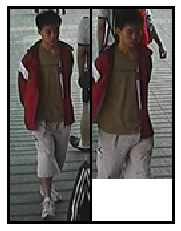


PART-1 DISTANCE => 0.5240087825565544
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.5523996131063301
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 5.009528634998059e-06
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.436241524375109
actual thresh => 0.19000000000000003
actual label => 0


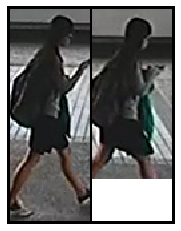


PART-1 DISTANCE => 0.3748586914594757
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.3950814479758577
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.7390660223368877
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4598338115447873
actual thresh => 0.19000000000000003
actual label => 0


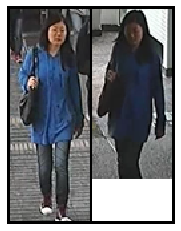


PART-1 DISTANCE => 0.5045864655602929
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.04145209983886381
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.3365605333371619
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.16822939977949097
actual thresh => 0.19000000000000003
actual label => 0



PART-1 DISTANCE => 0.13635359414668807
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.07767538316618645
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.3021340168921209
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.06042680337842418
actual thresh => 0.19000000000000003
actual label => 0


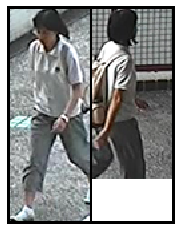


PART-1 DISTANCE => 0.43725676781309014
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.520842685831705
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.2789222093828272
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4557414069382065
actual thresh => 0.19000000000000003
actual label => 0



PART-1 DISTANCE => 0.2690668106364748
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 5.497464184747773e-06
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.6275247868004732
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.1793183194873896
actual thresh => 0.19000000000000003
actual label => 0


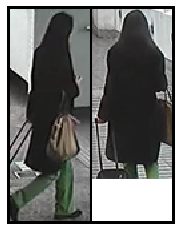


PART-1 DISTANCE => 0.34815653182108613
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.3622769577571567
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.14696871982739237
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.31639122498398975
actual thresh => 0.19000000000000003
actual label => 0



PART-1 DISTANCE => 0.13721445096119678
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.493442525332696
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.0902144077507062
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.2960655151996176
actual thresh => 0.19000000000000003
actual label => 0



PART-1 DISTANCE => 0.3952515932965759
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.07684958048867743
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.39606125869377534
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.15826257039807023
actual thresh => 0.19000000000000003
actual label => 0


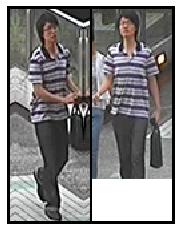


PART-1 DISTANCE => 0.3560528841793924
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.4779814915239864
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.07487278811627072
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.3579994717502703
actual thresh => 0.19000000000000003
actual label => 0



PART-1 DISTANCE => 0.2553497079906977
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.05110864250206996
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.3255177152332912
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.11617348464479779
actual thresh => 0.19000000000000003
actual label => 0



PART-1 DISTANCE => 0.19665201745658814
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.5725504988571947
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.11279278184131845
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4054192591738981
actual thresh => 0.19000000000000003
actual label => 0



PART-1 DISTANCE => 0.24432606539690804
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.26697137420122663
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.25027716835810976
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.25910347127173955
actual thresh => 0.19000000000000003
actual label => 0


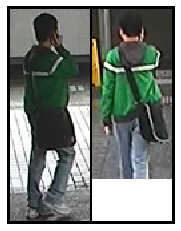


PART-1 DISTANCE => 0.4055075338142781
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.11346484331420374
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.07971933497118315
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.08110150676285563
actual thresh => 0.19000000000000003
actual label => 0


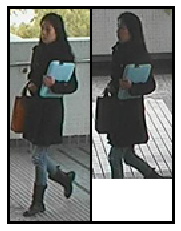


PART-1 DISTANCE => 0.17569037596845874
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.11137487489615469
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.416149736154303
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.11836802242455235
actual thresh => 0.19000000000000003
actual label => 0


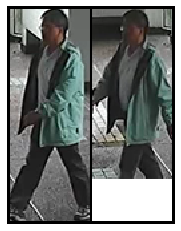


PART-1 DISTANCE => 0.38895038360005335
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 5.497464184747773e-06
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.28630010803812517
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.1350500983276357
actual thresh => 0.19000000000000003
actual label => 0


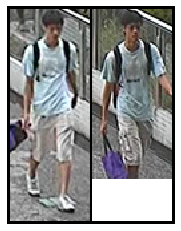


PART-1 DISTANCE => 0.15125516831449537
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.027737628809606864
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.38749123523026774
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.10774928070895264
actual thresh => 0.19000000000000003
actual label => 0


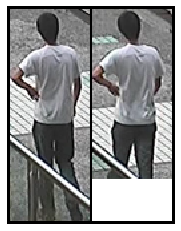


PART-1 DISTANCE => 0.5783357714112567
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.48701532433045186
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.13066616894950078
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4340095826704226
actual thresh => 0.19000000000000003
actual label => 0


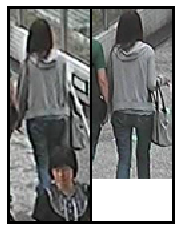


PART-1 DISTANCE => 0.2723303793470033
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.08233786547439714
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.21986311387961593
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.09843869864532385
actual thresh => 0.19000000000000003
actual label => 0


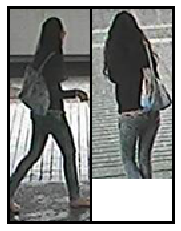


PART-1 DISTANCE => 0.221748787619393
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.1665273952947863
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 5.009528634998059e-06
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.1442661947007504
actual thresh => 0.19000000000000003
actual label => 0


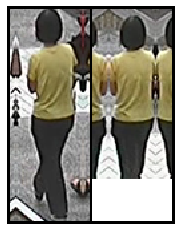


PART-1 DISTANCE => 0.3260973196741231
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.3482506430560661
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.3606007052776107
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.3462899908239865
actual thresh => 0.19000000000000003
actual label => 0


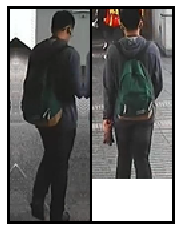


PART-1 DISTANCE => 0.5299048904847921
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.5106047049819916
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.20718937824977393
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4537816767361082
actual thresh => 0.19000000000000003
actual label => 0


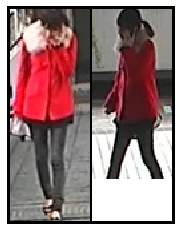


PART-1 DISTANCE => 0.5914840514358524
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 5.497464184747773e-06
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.4084129332424887
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.19997939693566824
actual thresh => 0.19000000000000003
actual label => 0


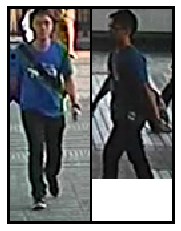


PART-1 DISTANCE => 0.2898152603184378
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.37536332102964504
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.37396163474752714
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.35797337163098003
actual thresh => 0.19000000000000003
actual label => 0


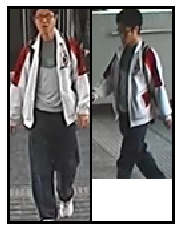


PART-1 DISTANCE => 0.5239491270170977
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.363722074429417
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.4148188952072413
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.40598684910251803
actual thresh => 0.19000000000000003
actual label => 0


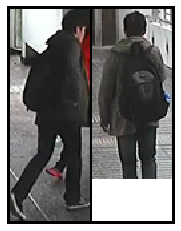


PART-1 DISTANCE => 0.07501068551848089
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 5.497464184747773e-06
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.218791455170301
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.043758291034060204
actual thresh => 0.19000000000000003
actual label => 0


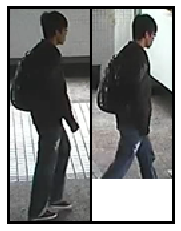


PART-1 DISTANCE => 0.161498860363474
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.5158827289094814
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.36096124583561273
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4140216585855062
actual thresh => 0.19000000000000003
actual label => 0


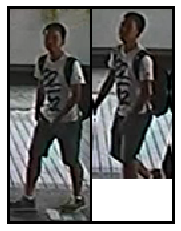


PART-1 DISTANCE => 0.07415105769935218
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 5.497464184747773e-06
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.35508592060749644
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.0710171841214993
actual thresh => 0.19000000000000003
actual label => 0


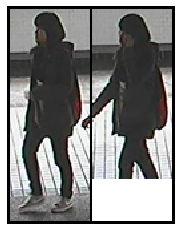


PART-1 DISTANCE => 0.8355981280938014
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.05234426562435377
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5575308295035081
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.2786257915194619
actual thresh => 0.19000000000000003
actual label => 0


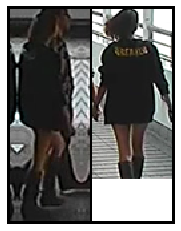


PART-1 DISTANCE => 0.11167993027520287
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.6753222289273803
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.15599238148585043
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.43639181365359825
actual thresh => 0.19000000000000003
actual label => 0


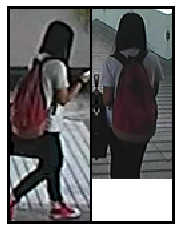


PART-1 DISTANCE => 0.14663302558874167
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.5420988993178618
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5588565504104372
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4370306496728045
actual thresh => 0.19000000000000003
actual label => 0


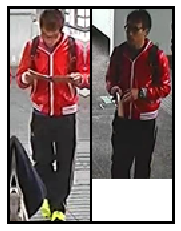


PART-1 DISTANCE => 0.5519199417682283
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.36944496351816053
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.37500358930648475
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.40705168432583894
actual thresh => 0.19000000000000003
actual label => 0


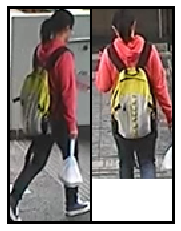


PART-1 DISTANCE => 0.556040281013268
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.38959920892779504
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.4618710611320124
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.43734179378573307
actual thresh => 0.19000000000000003
actual label => 0


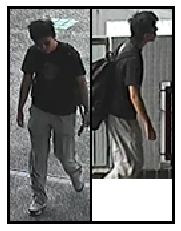


PART-1 DISTANCE => 0.2243599205378258
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.06494407210800862
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.26273530807123124
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.09741904572181141
actual thresh => 0.19000000000000003
actual label => 0


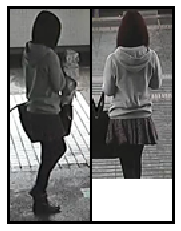


PART-1 DISTANCE => 0.0839460108656052
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.46892518375885345
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.6143614803228941
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4042274063198909
actual thresh => 0.19000000000000003
actual label => 0


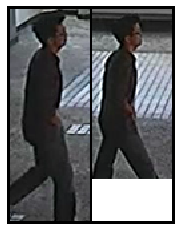


PART-1 DISTANCE => 0.46734630837168006
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.3597989487511859
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5774992499405125
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4248484809131501
actual thresh => 0.19000000000000003
actual label => 1


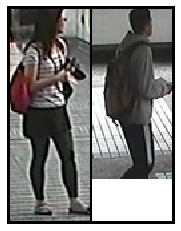


PART-1 DISTANCE => 0.4157702778844636
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.408739358715285
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.28142511724891905
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.3846826942558475
actual thresh => 0.19000000000000003
actual label => 1


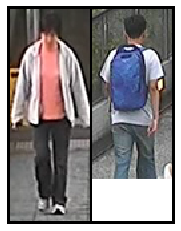


PART-1 DISTANCE => 0.5636153314570463
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.04160160827444566
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 5.009528634998059e-06
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.11272306629140927
actual thresh => 0.19000000000000003
actual label => 1


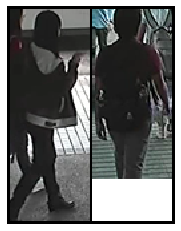


PART-1 DISTANCE => 0.4159241875168585
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.15609378672816618
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5357630052714244
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.2839937105945563
actual thresh => 0.19000000000000003
actual label => 1


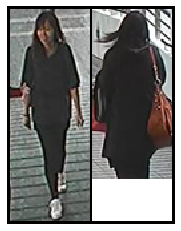


PART-1 DISTANCE => 0.5535237962959967
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.1341531006927964
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.39132862613382496
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.18897048448596435
actual thresh => 0.19000000000000003
actual label => 1


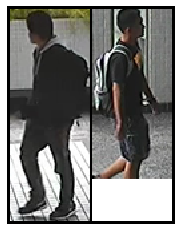


PART-1 DISTANCE => 0.40844430383769315
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.1560986524408674
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.24795916255990183
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.22493988474403945
actual thresh => 0.19000000000000003
actual label => 1


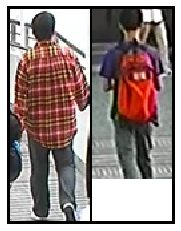


PART-1 DISTANCE => 0.2654560118388451
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.48511998442045134
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.1982532323288413
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.3838138394858081
actual thresh => 0.19000000000000003
actual label => 1


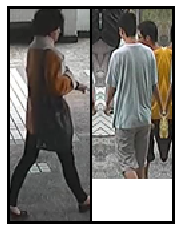


PART-1 DISTANCE => 0.30703262477653026
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.13405267296189485
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5354817725515598
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.168502879465618
actual thresh => 0.19000000000000003
actual label => 1


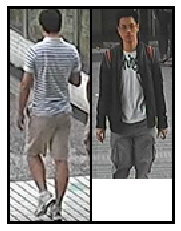


PART-1 DISTANCE => 0.20798333411740128
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.45517276813523533
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.2643441355271456
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.36756915481005054
actual thresh => 0.19000000000000003
actual label => 1


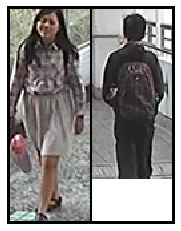


PART-1 DISTANCE => 0.7136516682352174
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.4045852564966243
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.2884643278886369
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4431743531227455
actual thresh => 0.19000000000000003
actual label => 1


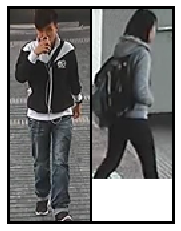


PART-1 DISTANCE => 0.391012606733841
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.3244630135745275
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.4302349137753571
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.3589273122465561
actual thresh => 0.19000000000000003
actual label => 1


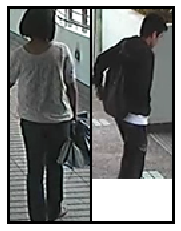


PART-1 DISTANCE => 0.28149696325094314
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.48416859277448615
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.24412372466134366
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.39562529324714907
actual thresh => 0.19000000000000003
actual label => 1


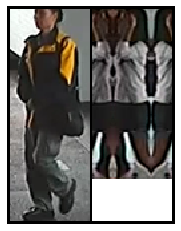


PART-1 DISTANCE => 0.43887879280419784
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 5.497464184747773e-06
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5122006333647996
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.1902158852337995
actual thresh => 0.19000000000000003
actual label => 1


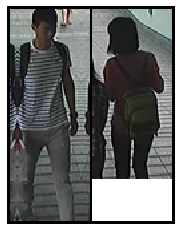


PART-1 DISTANCE => 0.10876212930284247
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.18416059331110474
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.20326695245287926
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.1511497464772387
actual thresh => 0.19000000000000003
actual label => 1


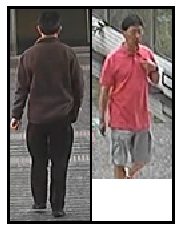


PART-1 DISTANCE => 0.30378048520447204
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.6611795136349434
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.2940218939250143
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.5162681840068634
actual thresh => 0.19000000000000003
actual label => 1


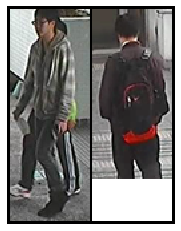


PART-1 DISTANCE => 0.524209321414505
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.07391254362198324
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.18692245155544707
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.14222635459399044
actual thresh => 0.19000000000000003
actual label => 1


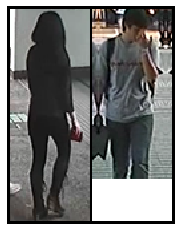


PART-1 DISTANCE => 0.2899113812398014
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.5512877398289516
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.4176195307678519
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4722788262989017
actual thresh => 0.19000000000000003
actual label => 1



PART-1 DISTANCE => 0.6674638853744115
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.4075545576725396
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.3749845343117642
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.45302241854075886
actual thresh => 0.19000000000000003
actual label => 1



PART-1 DISTANCE => 0.4602711945801905
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.5252707160904138
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.3813555005382904
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4834877686779444
actual thresh => 0.19000000000000003
actual label => 1



PART-1 DISTANCE => 0.3759375523489804
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.5406616604661654
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.3039784717619758
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4603802011018905
actual thresh => 0.19000000000000003
actual label => 1


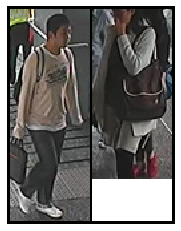


PART-1 DISTANCE => 0.23714016570964744
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.02964072887970788
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.29015190895154036
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.10545841493223757
actual thresh => 0.19000000000000003
actual label => 1


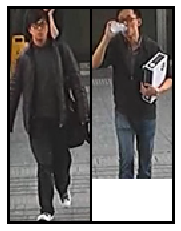


PART-1 DISTANCE => 0.6619345055190501
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.40383448861185733
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5089651374883849
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4764806217686014
actual thresh => 0.19000000000000003
actual label => 1


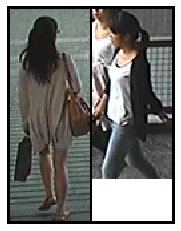


PART-1 DISTANCE => 0.8046571478329814
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.3153803788281719
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.28001971901642025
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4061636006667834
actual thresh => 0.19000000000000003
actual label => 1



PART-1 DISTANCE => 0.3809990220308156
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 5.497464184747773e-06
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.1905432172558654
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.11430844785733621
actual thresh => 0.19000000000000003
actual label => 1


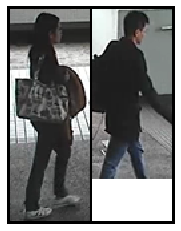


PART-1 DISTANCE => 0.2369827505883206
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.5513201199884752
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.2838904957486776
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.43496672126048475
actual thresh => 0.19000000000000003
actual label => 1


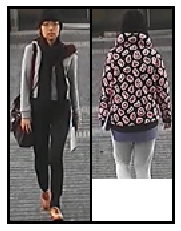


PART-1 DISTANCE => 0.6798625300735688
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.3609301400664911
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.26859907362110985
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4062504047788304
actual thresh => 0.19000000000000003
actual label => 1



PART-1 DISTANCE => 0.14090240162913553
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.2904638750373762
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.7455711125013222
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.3233925475226902
actual thresh => 0.19000000000000003
actual label => 1



PART-1 DISTANCE => 0.36954047064155093
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.5185055218308889
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5047158208817828
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4859545714032001
actual thresh => 0.19000000000000003
actual label => 1



PART-1 DISTANCE => 0.2991550651577051
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.4292799648834563
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.23461662828571977
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.3643223176187588
actual thresh => 0.19000000000000003
actual label => 1



PART-1 DISTANCE => 0.31285692203800913
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 5.497464184747773e-06
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.40060949063307133
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.1426932825342161
actual thresh => 0.19000000000000003
actual label => 1



PART-1 DISTANCE => 0.45183379385916334
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.2612580427624319
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5568246862365509
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.358486521676602
actual thresh => 0.19000000000000003
actual label => 1


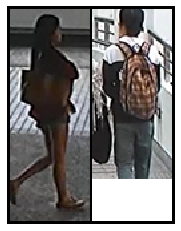


PART-1 DISTANCE => 0.12851722920844733
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.44047776548863515
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.46027688121359095
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.35634203553589927
actual thresh => 0.19000000000000003
actual label => 1


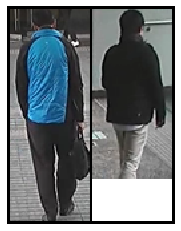


PART-1 DISTANCE => 0.5562449683788304
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.6119698965306194
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.13592344727129307
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.5056156210483963
actual thresh => 0.19000000000000003
actual label => 1


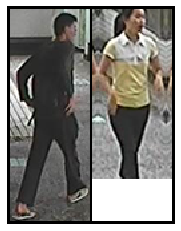


PART-1 DISTANCE => 0.6134613927850981
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.6025225360697021
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5939915326148668
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.6030041067218143
actual thresh => 0.19000000000000003
actual label => 1


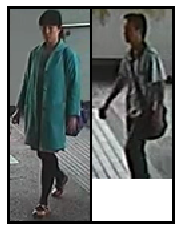


PART-1 DISTANCE => 0.33624060746762896
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.27853274201794315
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.2905690074786368
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.292481568200019
actual thresh => 0.19000000000000003
actual label => 1


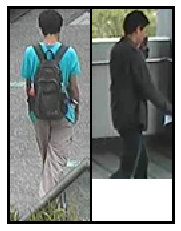


PART-1 DISTANCE => 0.21714437976367942
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.5184862906806889
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.40120602809244615
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4347618559796384
actual thresh => 0.19000000000000003
actual label => 1



PART-1 DISTANCE => 0.5085714804870382
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.2194912862615791
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.36498855327934876
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.30640677851022485
actual thresh => 0.19000000000000003
actual label => 1


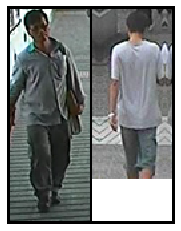


PART-1 DISTANCE => 0.14212809894555722
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.214054098499866
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.4676965583406932
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.22197177076805824
actual thresh => 0.19000000000000003
actual label => 1


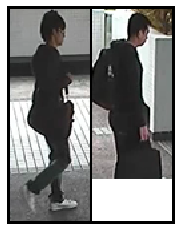


PART-1 DISTANCE => 0.29894749457935255
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.516169805958853
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.12455511073960616
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.39440240463910353
actual thresh => 0.19000000000000003
actual label => 1


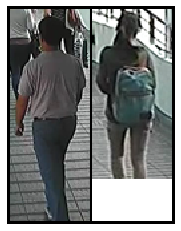


PART-1 DISTANCE => 0.42033201833939055
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.5343088353580684
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.24465808266426198
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4535833214155715
actual thresh => 0.19000000000000003
actual label => 1


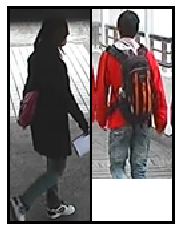


PART-1 DISTANCE => 0.3289950314983737
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.5320260630742337
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.05934435299689145
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.38501464414421493
actual thresh => 0.19000000000000003
actual label => 1


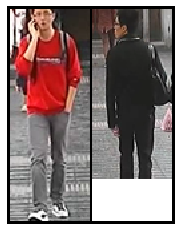


PART-1 DISTANCE => 0.2626490278760628
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.46025378862347716
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5443073493583903
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.43754354862097694
actual thresh => 0.19000000000000003
actual label => 1


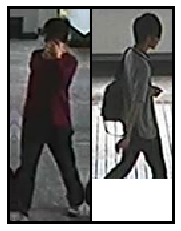


PART-1 DISTANCE => 0.3866878290336956
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.37115491398172973
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.2302081681636538
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.34607214782850776
actual thresh => 0.19000000000000003
actual label => 1


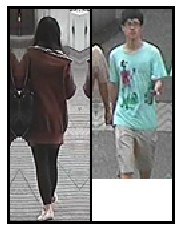


PART-1 DISTANCE => 0.3309648051400341
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.3342194916048499
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.3158587859149702
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.32989641317391083
actual thresh => 0.19000000000000003
actual label => 1


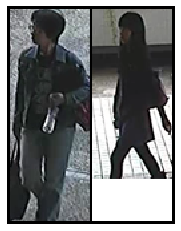


PART-1 DISTANCE => 0.4948032059998704
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 5.497464184747773e-06
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.3938506945624752
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.17773078011246912
actual thresh => 0.19000000000000003
actual label => 1


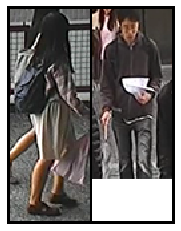


PART-1 DISTANCE => 0.5620942396561318
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.7594989428080654
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.3519350109611086
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.6385052158082873
actual thresh => 0.19000000000000003
actual label => 1


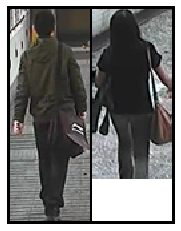


PART-1 DISTANCE => 0.5461012864771014
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.32540380491782217
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.3043376399380866
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.36533006823373093
actual thresh => 0.19000000000000003
actual label => 1


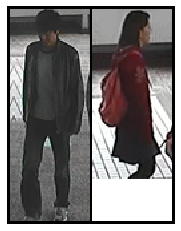


PART-1 DISTANCE => 0.3070008886933006
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.34135433521678893
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.5338322223022192
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.3729792233291773
actual thresh => 0.19000000000000003
actual label => 1


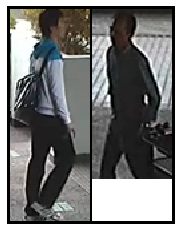


PART-1 DISTANCE => 0.3461705375146639
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.4067746823992922
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.2114745879212236
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.35559383452675286
actual thresh => 0.19000000000000003
actual label => 1


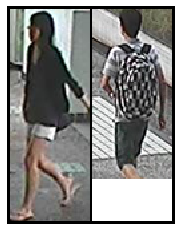


PART-1 DISTANCE => 0.552370635635166
Threshold => 0.20000000000000004
--------------------------------------------------
PART-2 DISTANCE => 0.35901299133706194
Threshold => 0.20000000000000004
--------------------------------------------------
PART-3 DISTANCE => 0.4125797749758197
Threshold => 0.15000000000000002
--------------------------------------------------
actual distance => 0.4083978769244343
actual thresh => 0.19000000000000003
actual label => 1


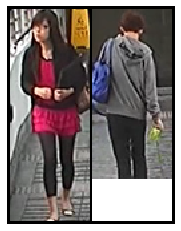

In [15]:
df = pd.read_csv(DATATEST_PATH)
with torch.no_grad():
    for index, data in df.iterrows():
        img1 = cv2.imread(IMAGES_PATH + data['image_1'])
        img2 = cv2.imread(IMAGES_OCCL_PATH + data['image_2'])
        label = data['label']

        img1_part = list(create_partial.partial_image_1(img1))
        img2_part = list(create_partial.partial_image_1(img2))

        thresholds = []
        dists = []
        for i, (input1, input2, model) in enumerate(zip(img1_part, img2_part, models)):
            input1 = cv_image2tensor(input1)
            input2 = cv_image2tensor(input2)
            out1, out2 = model['model'](input1, input2)
            euclidean_distance = F.pairwise_distance(out1, out2)
            
            dist = metrics.normalize_data(euclidean_distance.item(), model['max_dist'])
            dists.append(dist)
            thresholds.append(model['threshold'])
            print('PART-{} DISTANCE => {}'.format((i+1), dist))
            print('Threshold => {}'.format(model['threshold']))
            print('-'*50)
            
        cat_dist, cat_thresh = metrics.concatenate(dists, thresholds, [0.2, 0.6, 0.2])
        print('actual distance => {}'.format(cat_dist))
        print('actual thresh => {}'.format(cat_thresh))
        print('actual label => {}'.format(label))
        concatenated = torch.cat((cv_image2tensor(img1, False), cv_image2tensor(img2, False)),0)
        vis.imshow(torchvision.utils.make_grid(concatenated))
        print('='*50, end='\n\n')